# MCMC tutorial

## Linear model and parameter estimation problem:

In a real world application, we would have some observations of a system. In this tutorial, we will instead ﬁt a two parameter **linear model** to some pseudo observations that we generate. We choose this approach to reduce the complexity of learning and understanding MCMC. It is also useful in understanding the assumptions made according to the structure of the observations. (**This part was adapted from MCMC chapter1**).


**Suppose we have a linear model** for the amount of ice cream you will consume ($y$, in pints) after going on a bike ride of length $x$ (in miles).  So the ***true*** process model, based on the unknown true values of the slope and intercept parameters, which we can call $\alpha^*$ and $\beta^*$, is:

$$y_{true} = \alpha^* x + \beta^*$$

We want to make this more realistic by incorporating some normally-distributed uncertainty, say, with mean 0 and standard deviation $\sigma$.  Call these uncertain measurements $y_{meas}$:

$$y_{meas} = y_{true} + \epsilon = \alpha^* x + \beta^* + \epsilon$$

where $\epsilon \sim N(0, 1)$ is our normally-distributed measurement error.

Now we want to **estimate** $\alpha$ and $\beta$.  Call $\hat{\alpha}$ and $\hat{\beta}$ our estimates of these parameters.  They lead to a set of estimates of the response, $\hat{y}$:

$$\hat{y} = \hat{\alpha} x + \hat{\beta}$$

**This is also known as parameter estimation problem**

<br>

(**This part was adapted from Inclass notebook mcmc and practicum**)

## Generating synthetic data

Now we can generate the **synthetic data** using our linear model above, we fix the $x$ distance values at which we will estimate our ice cream intake covering the 0 to 9.9 range (inclusive), at intervals of 0.1 miles. Let $\alpha^* = 0.5$ and $\beta^* = 8$ represent the true parameters for our linear model. (**This part was adapted from practicum**)

In [1]:
# Some useful packages

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
np.random.seed(3202) # set the seed for random sampling.

astar, bstar = 0.5, 8 # set the true parameters for our linear model.

sigma = 1 # set the standard deviation for the normally-distributed uncertainty of our linear model.

# the x and y values of our true model.
x_grid = np.arange(0,10,0.1)
y_true = [astar*x + bstar for x in x_grid]

# the x and y values of our synthetic data set.
x_meas = np.arange(0,10,0.1)
y_measa = y_meas = [stats.norm.rvs(loc=y, scale=sigma) for y in y_true]

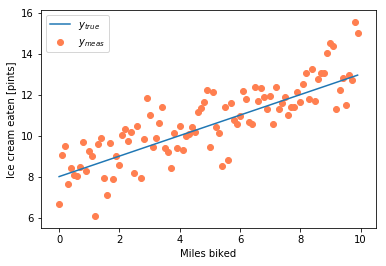

In [3]:
# We can create a scatter plot of our true model and the "observed" data (synthetic data)

plt.plot(x_grid, y_true, label='$y_{true}$')
plt.scatter(x_grid, y_meas, color='coral', label='$y_{meas}$')
plt.xlabel('Miles biked')
plt.ylabel('Ice cream eaten [pints]')
plt.legend()
plt.show()

## Likelihood function

<br>

The **likelihood function** describes the plausibility of a parameter value based on observations. Generally, we seek parameter values that maximize the likelihood function.

For this example, we know the data are all normally distributed with mean 0 and standard deviation $\sigma$, we will use the product of normal distributions for each data point to represent the likelihood function

$$L(y_{meas} \mid (\alpha, \beta)) = \prod_{i=1}^N f(\hat{y}_i-y_i \mid \mu=0, \sigma)$$

where $f(\hat{y}_i-y_i \mid \mu=0, \sigma)$ is a normal pdf evaluated at $\hat{y}_i - y_i$, with mean 0 and standard deviation $\sigma$, and $\hat{y} = \alpha x + \beta$ (evaluated at the `x_grid` points)

<br>

(**This part was adapted from Inclass notebook mcmc**)

In [4]:
def likelihood(parameters, x_meas=x_meas, y_meas=y_meas, sigma=1):
    alpha, beta = parameters #unpack the parameters
    prod = 1 # initilize the product to 1
    
    for i in range(len(x_meas)): 
        delta = alpha*x_meas[i] + beta - y_meas[i]  # the difference between the measured data and model data
        prod *= stats.norm.pdf(x=delta, loc=0, scale=sigma) # calculate the pdf
        
    return prod

## Prior distributions

 The **prior probability** is the probability that an event or observation will occur before taking into account new evidence. It is based on background information.

For this exmaple, we will use uniform prior distributions, for $\alpha \in [0,5]$ and $\beta \in [0,15]$. You may assume that $\alpha$ and $\beta$ are independent, so their prior distribution factors as $\pi(\alpha, \beta) = \pi(\alpha) \pi(\beta)$.

<br>

(**This part was adapted from practicum**)

In [5]:
def prior(parameters):
    alpha, beta = parameters # unpack the parameters
    if 0 <= alpha <= 5 and 0 <= beta <= 15: # we want to make sure alpha and beta stay in the range.
        return (1/5)*(1/15) # if it is true then we return the product of their pdf
    else:
        return 0 # if it is not true, we return 0

## Posterior distribution/posterior *score*

To compute the acceptance probabilities for the Metropolis-Hastings algorithm, we need the posterior probability.

The **posterior probability** is the probability that an event or observation will occur after taking into account all evidence and background information.

in light of the uncertainties in both the parameters and the observations. Bayes’ theorem deﬁnes the posterior probability as proportional to the likelihood of the observations given the parameters times the prior probability of the parameters:

$$\text{posterior distribution} = \pi((\alpha, \beta) \mid y_{meas}) = L(y_{meas} \mid (\alpha, \beta)) \times \pi(\alpha, \beta)$$

Where the $L(y_{meas} \mid (\alpha, \beta))$ is the likelihood function and the $\pi(\alpha, \beta)$ is the prior distribution for $\alpha \ and \  \beta$

The posterior distribution therefore summarizes information about the parameters based on the prior distribution and what the likelihood function says about more “likely” parameter values. The posterior therefore provides a range of parameter values, and says which values are more probable than others. 

In this analysis, you will work with the **log-probability distributions** for numerical stability reasons. That is, the probabilities involved may be very small, and computers may not be able to distinguish them from 0 in many cases. 

In [6]:
def logpost(parameters, x_meas=x_meas, y_meas=y_meas, sigma=1):
    L = likelihood(parameters, x_meas, y_meas, sigma) # calculate the likelihood
    pi = prior(parameters) # calculate the prior
    return np.log(L*pi)  # return the log of the posterior

## Couple examples of parameter fits

Provide examples of:

1. parameters that have high prior probability but low likelihood
2. parameters that have low prior probability but high likelihood
3. parameters that have bad both
4. parameters that have good both



(one figure with 4 linear fits on it, and legend)

## What is a Markov chain?

A Markov chain is "a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event.

(This part was adapted from wiki)

## Metropolis-Hastings algorithm

Introduce as a way to formalize the notion that "Hey, *these* parameters were pretty good, let me propose some more parameters that 'look like' them!" (i.e., use a Markov chain)

todo...

### Stationary distribution

Todo...  review the fact that if you choose your transition probabilities (acceptance probabilities) in THIS special way, then the stationary distribution just happens to be the posterior distribution of your model parameters!

In [42]:
# First, let's set up some classes for our Metropolis-Hastings algorithm

class State: # This is the class for the state in Markov chain
    def __init__(self, state, value):
        self.state = state # The currnent state 
        self.value = value # The corresponding log-posterior score for the current state
        
class ProblemMCMC: # This is the class to set the specific problem we want to solve by using Metropolis-Hastings algorithm
    def __init__(self, initial, logposterior, stepsize, x_meas, y_meas, sigma):
        self.current = initial # The initial state
        self.logpost = logposterior # The log-posterior function
        self.stepsize = stepsize # The step size to draw samples from mulitvariare normal distirbution
        self.x = x_meas 
        self.y = y_meas
        self.sigma = sigma
        
    def random_move(self): # This is the function to pick a random move by drawing from a multivariate normal distribution
        next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        return next_move, self.logpost(next_move, self.x, self.y, self.sigma)

In [43]:
# Let's code up the Metropolis-Hastings algorithm!

def mcmc(problem, n_iter):
    
    # want to keep growing these lists to track the parameter estimates
    alpha = [problem.current.state[0]]
    beta = [problem.current.state[1]]
    lpost = [problem.current.value]
    n_accept = 0
    S = 0
    
    for t in range(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move()
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            # the proposed move is an improvement, so accept w.p. 1
            n_accept += 1
            alpha.append(nextMove[0])
            beta.append(nextMove[1])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            # the proposed move is worse; accept with probability exp[delta_obj/T]
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                alpha.append(nextMove[0])
                beta.append(nextMove[1])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                alpha.append(alpha[-1])
                beta.append(beta[-1])
                lpost.append(lpost[-1])

    return (alpha, beta, lpost, n_accept/S)

In [44]:
def sequences_generator(stepsize=[0.003, 0.02], n_iter=5000, x_meas=x_meas, y_meas=y_meas, sigma=1, logpost=logpost, m=3):
    problems = []
    burn_in = int(n_iter/2)
    bestfit = stats.linregress(x=x_meas, y=y_meas)
    slope, intercept = bestfit.slope, bestfit.intercept
    for i in range(m):
        theta = stats.multivariate_normal.rvs([bestfit.slope, bestfit.intercept], [0.01, 0.1])
        state = State(theta, logpost(theta, x_meas, y_meas, sigma))
        problems.append(ProblemMCMC(state, logpost, stepsize, x_meas, y_meas, sigma))
    alphas = []
    betas = []
    alphas_ana = []
    betas_ana = []
    ars = []
    for i in range(m):
        alpha, beta, lpost, ar = mcmc(problems[i], n_iter)
        alphas_ana.append(alpha[burn_in:])
        betas_ana.append(beta[burn_in:])
        alphas.append(alpha)
        betas.append(beta)
        ars.append(ar)
    return alphas, betas, alphas_ana, betas_ana, ars

In [40]:
def plot(alphas, betas):
    m = len(alphas)
    for i in range(m):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
        ax[0].plot(alphas[i])
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('alpha')
        ax[0].set_title('Sequence{}'.format(i+1))
        ax[1].plot(betas[i])
        ax[1].set_xlabel('Iteration')
        ax[1].set_ylabel('beta')
        ax[1].set_title('Sequence{}'.format(i+1))
        plt.show()

In [45]:
alphas, betas, alphas_ana, betas_ana, ars = sequences_generator(n_iter=4000, m=4)

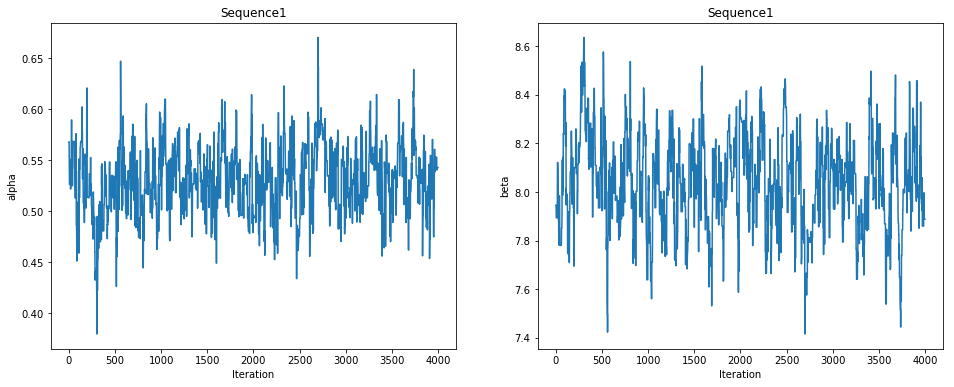

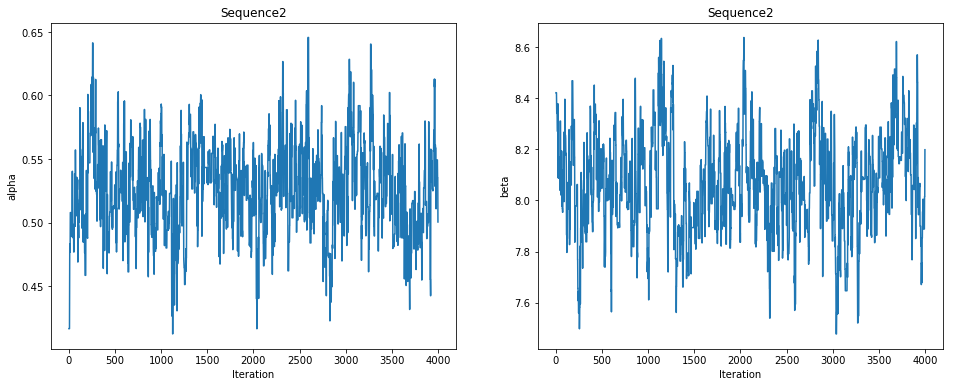

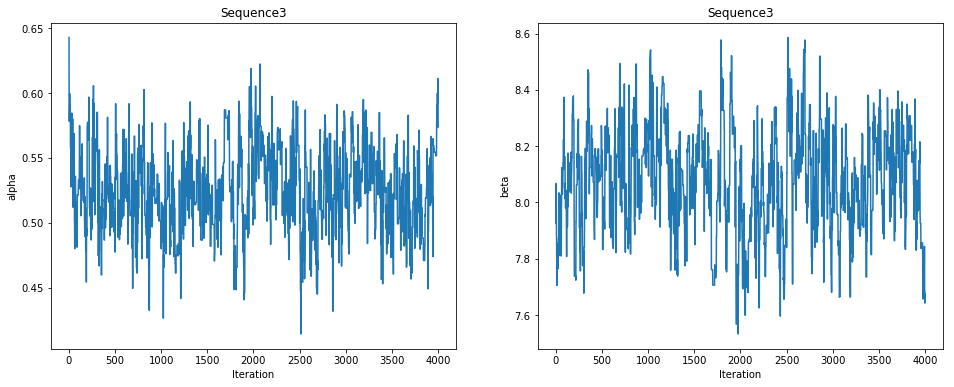

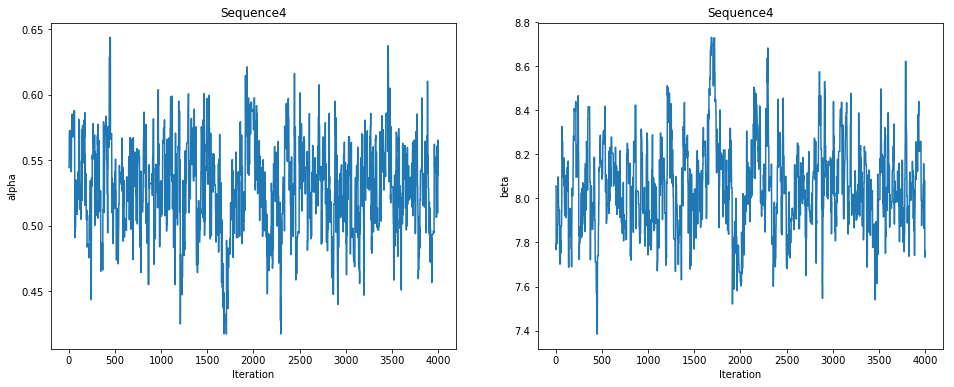

In [46]:
plot(alphas, betas)

## Convergence/stationarity diagnostics


Steps for the **Gelman and Rubin diagnostic**:

1. Run m>= 2 chains of length 2n from different initial values

<br>

2. Burn-in (Discard) the first n draws in each chain

<br>

3. Calculate the within-chain and between-chain variance

$$ Between-chain \ variance = B =  \dfrac{n}{m-1}\sum\limits_{i=1}^m (\overline{\theta_i}-\overline{\overline{\theta}})^2 $$
$$ \overline{\overline{\theta}} =  \dfrac{1}{m}\sum\limits_{i=1}^m \overline{\theta_i} $$

$$ Within-chain \ variance = W = \dfrac{1}{m}\sum\limits_{i=1}^m s_{i}^{2}$$

4. Calculate the potential scale reduction factoe.

In [51]:
def GR_diag(alphas, betas, discard, m, interval=100):
    GR_alpha = []
    GR_beta = []
    for n in range(100, discard, 100):
        sequences_a = []
        sequences_b = []
        for i in range(m):
            sequences_a.append(alphas[i][:n])
            sequences_b.append(betas[i][:n])
        GR_alpha.append(cal_GR(sequences_a))
        GR_beta.append(cal_GR(sequences_b))
    return GR_alpha, GR_beta

In [52]:
def cal_GR(sequences):
    m = len(sequences)
    n = len(sequences[0])
    u = []
    s = []
    for i in range(m):
        u.append(np.mean(sequences[i]))
        s.append(np.var(sequences[i]))
    U = np.mean(u)
    B = 0
    W = 0
    for i in range(m):
        B += (u[i]-U)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    return np.sqrt(((n-1)/n) + ((m+1)*B)/(m*n*W))

In [65]:
def plot_GR(GRs, interval=100):
    n_params = len(GRs)
    n_points = len(GRs[0])
    fig, ax = plt.subplots(nrows=1, ncols=n_params, figsize=(16,6))
    x = np.arange(interval, interval*(n_points+1), interval)
    for i in range(len(GRs)):
        ax[i].scatter(x=x, y=GRs[i])
        ax[i].set_xlabel('Iteration')
        ax[i].set_ylabel('Potential scale reduction factor')
        ax[i].set_title('GR diagnostic for parameter{}'.format(i+1))
    plt.show()
    

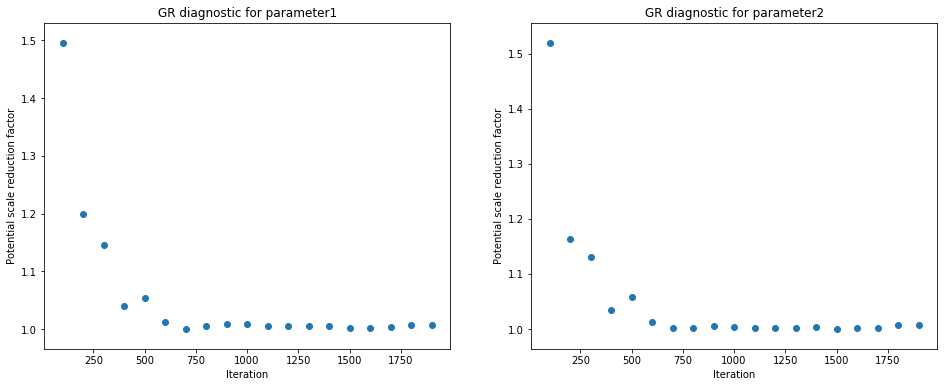

In [66]:
GR_a, GR_b = GR_diag(alphas_ana, betas_ana, int(n_iter/2), 4)
plot_GR([GR_a, GR_b])

## Thinning

Todo ... (independence of samples)

## Online adaptation of the proposal covariance matrix

Todo... (Haario 2001)